In [12]:
import pandas as pd
import re
from transformers import pipeline

# Load data
data = pd.read_csv('Restaurant_reviews.csv')
data = data[['Restaurant', 'Review']].dropna().reset_index(drop=True)
data = data[['Restaurant', 'Review']].drop_duplicates()

data.head()


,Restaurant,Review
0,Beyond Flavours,"The ambience was good, food was quite good . h..."
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...


In [13]:
# Add columns for aspect-based sentiment analysis
data['Food Quality Sentiment'] = ''
data['Service Sentiment'] = ''
data['Ambiance Sentiment'] = ''

# Define keywords for each aspect
food_keywords = ['food', 'taste', 'flavor', 'meal', 'dish', 'cuisine', 'delicious', 'bland']
service_keywords = ['service', 'staff', 'waiter', 'waitress', 'attentive', 'slow', 'friendly', 'rude']
ambiance_keywords = ['ambiance','ambience', 'atmosphere', 'environment', 'decor', 'vibe', 'music', 'noisy', 'quiet']

# Function to extract aspect-specific text based on keywords
def extract_aspect_text(review, keywords):
    sentences = re.split(r'[.,!?]', review)  # Split review into sentences
    aspect_text = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return ' '.join(aspect_text)

# Apply extraction for each aspect
data['Food Text'] = data['Review'].apply(lambda x: extract_aspect_text(x, food_keywords))
data['Service Text'] = data['Review'].apply(lambda x: extract_aspect_text(x, service_keywords))
data['Ambiance Text'] = data['Review'].apply(lambda x: extract_aspect_text(x, ambiance_keywords))



In [15]:
# Initialize a sentiment analysis pipeline using a pre-trained model
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)

# Function to analyze sentiment and debug output
def analyze_sentiment_debug(aspect_text, aspect_name=""):
    # print(f"Analyzing sentiment for {aspect_name}: '{aspect_text}'")
    
    
    # Limit input to 512 characters to avoid exceeding model limits
    aspect_text = aspect_text[:512] if len(aspect_text) > 512 else aspect_text
    
    if aspect_text.strip():  # Ensure there is text to analyze
        result = sentiment_analyzer(aspect_text)[0]
        sentiment = result['label'].lower()
    else:
        sentiment = 'neutral'  # If no text is extracted for the aspect
        
        
    # print(f"Sentiment for {aspect_name}: {sentiment}")
    return sentiment

# Apply the sentiment analysis model to each aspect with debug info
data['Food Quality Sentiment'] = data['Food Text'].apply(lambda x: analyze_sentiment_debug(x, "Food Quality"))
data['Service Sentiment'] = data['Service Text'].apply(lambda x: analyze_sentiment_debug(x, "Service"))
data['Ambiance Sentiment'] = data['Ambiance Text'].apply(lambda x: analyze_sentiment_debug(x, "Ambiance"))

# Display sample to verify results
print(data[['Review', 'Food Quality Sentiment', 'Service Sentiment', 'Ambiance Sentiment']].head())

# Save the dataset with aspect sentiments to a CSV file
data[['Restaurant' ,'Review', 'Food Quality Sentiment', 'Service Sentiment', 'Ambiance Sentiment']].to_csv('Restaurant_Reviews_with_Aspect_Sentiment_Updated.csv', index=False)

print("Processed data saved as 'Restaurant_Reviews_with_Aspect_Sentiment_Updated.csv'")

KeyboardInterrupt: 

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os

# Save the model and tokenizer for future use
model_dir = "saved_sentiment_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sentiment_analyzer.model.save_pretrained(model_dir)
sentiment_analyzer.tokenizer.save_pretrained(model_dir)
print(f"Model and tokenizer saved in '{model_dir}'.")



Model and tokenizer saved in 'saved_sentiment_model'.


In [ ]:
# Function to load the saved model and analyze a new review
def analyze_new_review(review):
    # Reload the model and tokenizer using the saved directory
    loaded_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_dir)
    # sentiment_model = pipeline("sentiment-analysis", model=loaded_model, tokenizer=loaded_tokenizer, truncation=True)
    
    # Extract text for each aspect
    food_text = extract_aspect_text(review, food_keywords)
    service_text = extract_aspect_text(review, service_keywords)
    ambiance_text = extract_aspect_text(review, ambiance_keywords)

    # Analyze each aspect
    food_sentiment = analyze_sentiment_debug(food_text, "Food Quality")
    service_sentiment = analyze_sentiment_debug(service_text, "Service")
    ambiance_sentiment = analyze_sentiment_debug(ambiance_text, "Ambiance")

    return {
        'Review': review,
        'Food Quality Sentiment': food_sentiment,
        'Service Sentiment': service_sentiment,
        'Ambiance Sentiment': ambiance_sentiment
    }

In [ ]:
# Example usage
# new_review = "The pasta was absolutely delicious, perfectly cooked with a great blend of spices. However, the service was disappointing; the waiter took too long to attend to us, and we had to wait ages for our drinks. The ambiance was charming and cozy, with beautiful decor and soft lighting."
# result = analyze_new_review(new_review)
# print(result)


{'Review': 'The pasta was absolutely delicious, perfectly cooked with a great blend of spices. However, the service was disappointing; the waiter took too long to attend to us, and we had to wait ages for our drinks. The ambiance was charming and cozy, with beautiful decor and soft lighting.', 'Food Quality Sentiment': 'positive', 'Service Sentiment': 'negative', 'Ambiance Sentiment': 'positive'}


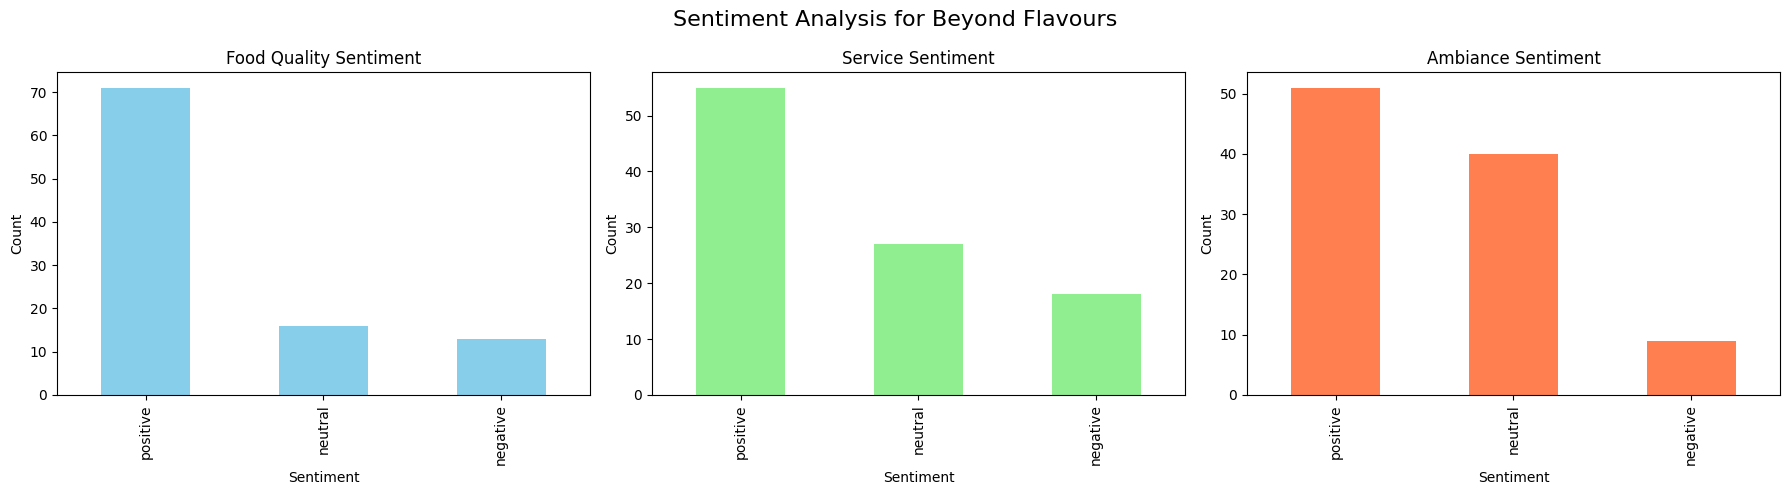

In [20]:
#write the code that ask the restaurant name and group by the review based on the analysis , plot its graph of the restaturant, based on the three aspects
restaurant_name = input("Enter the name of the restaurant: ")
restaurant_data = data[data['Restaurant'] == restaurant_name]

# Group by the sentiment of each aspect
food_sentiment_counts = restaurant_data['Food Quality Sentiment'].value_counts()
service_sentiment_counts = restaurant_data['Service Sentiment'].value_counts()
ambiance_sentiment_counts = restaurant_data['Ambiance Sentiment'].value_counts()

# Plot the sentiment distribution for each aspect
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Sentiment Analysis for {restaurant_name}", fontsize=16)

food_sentiment_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Food Quality Sentiment")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")

service_sentiment_counts.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title("Service Sentiment")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count")

ambiance_sentiment_counts.plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_title("Ambiance Sentiment")
axes[2].set_xlabel("Sentiment")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

